In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('gdrive/MyDrive/CRISPR_DeepHF')

In [ ]:
!ls

deephf_data.xlsx  test.csv   Type1  Type3
models		  train.csv  Type2  word2vec_model_rnn


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

In [ ]:
file_name = "deephf_data.xlsx"
df = pd.read_excel(file_name, sheet_name="Sheet1")
df.columns = df.iloc[0]
df.drop(df.index[0], inplace=True)
df['Wt_Efficiency'] = pd.to_numeric(df['Wt_Efficiency'])
df['eSpCas 9_Efficiency'] = pd.to_numeric(df['eSpCas 9_Efficiency'])
df['SpCas9-HF1_Efficiency'] = pd.to_numeric(df['SpCas9-HF1_Efficiency'])
df.head(3)

,NaN,gRNA,gRNA_Seq,PAM,21mer,Wt_Efficiency,eSpCas 9_Efficiency,SpCas9-HF1_Efficiency
1,NaN,gRNA-1,AAAAAAAAACTCCAAAACCC,TGG,AAAAAAAAACTCCAAAACCCT,0.168570,0.142063,0.093147
2,NaN,gRNA-2,AAAAAACAACAAGAAGCACA,AGG,AAAAAACAACAAGAAGCACAA,0.099624,0.051901,0.064951
3,NaN,gRNA-3,AAAAAACACAAGCAAGACCG,TGG,AAAAAACACAAGCAAGACCGT,0.247750,0.043573,0.061797


In [ ]:
df1 = df[['21mer','Wt_Efficiency','eSpCas 9_Efficiency','SpCas9-HF1_Efficiency']]
df1.head(3)

,21mer,Wt_Efficiency,eSpCas 9_Efficiency,SpCas9-HF1_Efficiency
1,AAAAAAAAACTCCAAAACCCT,0.168570,0.142063,0.093147
2,AAAAAACAACAAGAAGCACAA,0.099624,0.051901,0.064951
3,AAAAAACACAAGCAAGACCGT,0.247750,0.043573,0.061797


In [ ]:
df1 = df1.sample(frac=1).reset_index(drop=True)
df1 = df1.dropna().reset_index(drop=True)
df1.head(3)

,21mer,Wt_Efficiency,eSpCas 9_Efficiency,SpCas9-HF1_Efficiency
0,ACCAGACCTCGATACAGCATT,0.819149,0.303657,0.513349
1,GCAGCTCAGAAAGAATCCGTG,0.923457,0.668363,0.767245
2,GCGGACCCACGAGAGCGCGTC,0.851161,0.529361,0.636398


**Individual**

In [ ]:
cas_name = 'Wt_Efficiency'

# df1 = df[['21mer','Wt_Efficiency','eSpCas 9_Efficiency','SpCas9-HF1_Efficiency']]
df1 = df[['21mer', cas_name]]

df1 = df1.sample(frac=1).reset_index(drop=True)
#df1 = df1.dropna().reset_index(drop=True)

df1 = df1[df1[cas_name].notna()]

print(df1.shape)
df1.head(3)

In [ ]:
print("Full dataset size after dropping null: ", df1.shape)
train_set_size = int(df1.shape[0]*0.85) # 85% as training set, like deephf paper
train_set = df1.iloc[:train_set_size].copy().reset_index(drop=True)
test_set = df1.iloc[train_set_size:].copy().reset_index(drop=True)
print("Train set size: ", train_set.shape)
print("Test set size: ", test_set.shape)

Full dataset size after dropping null:  (53937, 4)
Train set size:  (45846, 4)
Test set size:  (8091, 4)


In [ ]:
train_set.to_csv("train.csv",index=False)
test_set.to_csv("test.csv",index=False)

**Load CSV from Drive**

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

**K-mer split**

In [ ]:
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [ ]:
def Gen_Words(sequence,kmer_len,s):
    
    kmer_list=[]
    for j in range(0,(len(sequence)-kmer_len)+1,s):

          kmer_list.append(sequence[j:j+kmer_len])


    return kmer_list


def word_generation_all_sequences(seq_set,kmer_len,stride):
    seq_set_enc = []
    for i in tqdm(range(len(seq_set))):
        seq_set_enc.append(Gen_Words(seq_set[i],kmer_len,stride))
    #seq_set_enc = np.array(seq_set_enc)
    return seq_set_enc



In [ ]:
#split all sequences to kmers
def splitkmer(data_df):
  kmer_len = 3
  stride = 2
  sequence_words = word_generation_all_sequences(data_df['21mer'],kmer_len,stride)
  #print(sequence_words)
  #print(len(sequence_words))
  return sequence_words

**Word2vec**

In [ ]:
from gensim.models import Word2Vec
def return_vectors_word2vec(data_df):
  sentences_constructed = splitkmer(data_df)
  model_ted = Word2Vec(sentences=sentences_constructed, size = 32, window=5, min_count=5, workers=4, sg=1)

  vector_list = []
  for sentence in sentences_constructed:
    vector = []
    for word in sentence:
      vector.append(model_ted.wv[word])
    vector_list.append(vector)
  vector_list = np.array(vector_list)
  
  return model_ted, vector_list
def return_vectors_only(data_df,model_word2vec):
  sentences_constructed = splitkmer(data_df)
  model_ted = model_word2vec
  vector_list = []
  for sentence in sentences_constructed:
    vector = []
    for word in sentence:
      vector.append(model_ted.wv[word])
    vector_list.append(vector)
  vector_list = np.array(vector_list)
  
  return vector_list



In [ ]:
#test a random kmer
#model_testing = return_vectors_word2vec(train_df,1)
#model_testing.wv.most_similar('ATG')

100%|██████████| 45846/45846 [00:00<00:00, 144111.21it/s]
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('AAG', 0.922577440738678),
 ('AGG', 0.8956265449523926),
 ('ACG', 0.8757708072662354),
 ('TTG', 0.6343978643417358),
 ('AAT', 0.6218340992927551),
 ('GTG', 0.6175557374954224),
 ('TAG', 0.6112311482429504),
 ('ATA', 0.6071228384971619),
 ('GAG', 0.5990007519721985),
 ('ATC', 0.5986645817756653)]

**CNN**

In [ ]:
import numpy as np
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D, Conv1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.utils import np_utils
from scipy import stats

def get_model_name(k):
    return 'model_'+str(k)+'.h5'


def create_new_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(10,32)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='linear'))
    return model
test_model = create_new_model()
print(test_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 8, 64)             6208      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 6, 64)             12352     
_________________________________________________________________
dropout_3 (Dropout)          (None, 6, 64)             0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 3, 64)             0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               19300     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_type = 1
target_col = ''
if target_type == 1:
  target_col = 'Wt_Efficiency'
elif target_type == 2:
  target_col = 'eSpCas 9_Efficiency'
else:
  target_col = 'SpCas9-HF1_Efficiency'

train_data = pd.read_csv('train.csv')

#word2vec_cnn_model, X = return_vectors_word2vec(train_data)
word2vec_cnn_model = Word2Vec.load('word2vec_model_rnn')
X = return_vectors_only(train_data,word2vec_cnn_model)
Y = train_data[[target_col]]

print(X.shape)
print(Y.shape)

100%|██████████| 45846/45846 [00:00<00:00, 144308.05it/s]


(45846, 10, 32)
(45846, 1)


In [ ]:
kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'cnn/'
'''
try:
    os.mkdir(save_dir_primary)
except:
    pass
'''
os.chdir(save_dir_primary)

try:
    os.mkdir('cnn/')
except:
    pass

os.chdir('cnn/')
save_dir_2 = 'saved_models/'
try:
    os.mkdir(save_dir_2)
except:
    pass
os.chdir('..')
os.chdir('..')

fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]

    #print(X_train.shape)
    #print(Y_train.shape)
    #print(X_val.shape)
    #print(Y_val.shape)
    
    # CREATE NEW MODEL
    model = create_new_model()
    # COMPILE NEW MODEL
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+save_dir_2+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=50,
                batch_size=64,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

Epoch 1/50
571/574 [============================>.] - ETA: 0s - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 00001: val_loss improved from inf to 0.02628, saving model to Type2/cnn/saved_models/model_1.h5
574/574 [==============================] - 3s 6ms/step - loss: 0.0319 - mean_squared_error: 0.0319 - val_loss: 0.0263 - val_mean_squared_error: 0.0263
Epoch 2/50
571/574 [============================>.] - ETA: 0s - loss: 0.0257 - mean_squared_error: 0.0257
Epoch 00002: val_loss improved from 0.02628 to 0.02153, saving model to Type2/cnn/saved_models/model_1.h5
574/574 [==============================] - 3s 6ms/step - loss: 0.0257 - mean_squared_error: 0.0257 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 3/50
574/574 [==============================] - ETA: 0s - loss: 0.0227 - mean_squared_error: 0.0227
Epoch 00003: val_loss improved from 0.02153 to 0.01982, saving model to Type2/cnn/saved_models/model_1.h5
574/574 [==============================] - 3s 6ms/step - loss: 0.0

100%|██████████| 8091/8091 [00:00<00:00, 137771.35it/s]


SpearmanrResult(correlation=0.7930515235254962, pvalue=0.0)


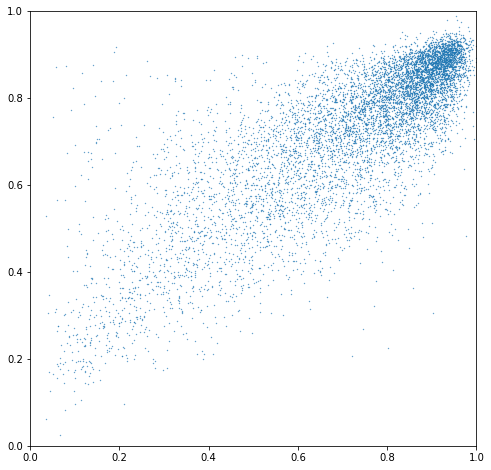

In [ ]:
import matplotlib.pyplot as plt
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'cnn/'
model = create_new_model()
    # COMPILE NEW MODEL
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    

fold_var = 3
model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('test.csv')



X_ = return_vectors_only(test_data,word2vec_cnn_model)

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))
savefigstring = 'cnn' + str(target_type) + '.png'
plt.savefig(savefigstring)

**LSTM**

In [ ]:
from keras.layers.recurrent import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout
from scipy import stats

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

def LSTM_model(word_model):
  pretrained_weights = word_model.wv.syn0
  vocab_size, emdedding_size = pretrained_weights.shape

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, 
                      weights=[pretrained_weights]))
  model.add(LSTM(units=emdedding_size,return_sequences = True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = emdedding_size, return_sequences=False))
  model.add(Dropout(0.2))  
  model.add(Dense(1,activation = 'sigmoid'))
  return model
#word_model = return_vectors_word2vec(train_df,1)
#test_model = LSTM_model(word_model)
#print(test_model.summary())

In [ ]:
def word2idx(word, word_model):
  return word_model.wv.vocab[word].index
def idx2word(idx, word_model):
  return word_model.wv.index2word[idx]

In [ ]:
#word_model, vectors_returned = return_vectors_word2vec(train_df)
word_model = Word2Vec.load('word2vec_model_rnn')
sentences = splitkmer(train_df)
#print(len(sentences[0]))
max_sentence_len = len(sentences[0])
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence):
    train_x[i, t] = word2idx(word, word_model)
print(train_x.shape)
print(train_x)


100%|██████████| 45846/45846 [00:00<00:00, 141566.41it/s]


(45846, 10)
[[10  1 14 ...  1  4 48]
 [ 4  6 32 ... 31 54 12]
 [52  5 10 ... 52 52 34]
 ...
 [18 60 63 ...  6 13 12]
 [27 54  9 ... 19 44 26]
 [10 32  3 ... 30 38  1]]


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_type = 3
target_col = ''
if target_type == 1:
  target_col = 'Wt_Efficiency'
elif target_type == 2:
  target_col = 'eSpCas 9_Efficiency'
else:
  target_col = 'SpCas9-HF1_Efficiency'

train_data = pd.read_csv('train.csv')

X = train_x
#X = np.array(X)



Y = train_data[[target_col]]
#Y = Y[indices]
print(X.shape)
print(Y.shape)
#print(X)

(45846, 10)
(45846, 1)


In [ ]:
kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'lstm/'
'''
try:
    os.mkdir(save_dir_primary)
except:
    pass
'''

os.chdir(save_dir_primary)

try:
    os.mkdir('lstm/')
except:
    pass

os.chdir('lstm/')
save_dir_2 = 'saved_models/'
try:
    os.mkdir(save_dir_2)
except:
    pass
os.chdir('..')
os.chdir('..')

fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]

    print(X_train.shape)
    print(Y_train.shape)
    print(X_val.shape)
    print(Y_val.shape)
    
    # CREATE NEW MODEL
    model = LSTM_model(word_model)
    # COMPILE NEW MODEL
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+save_dir_2+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=50,
                batch_size=64,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

(36676, 10)
(36676, 1)
(9170, 10)
(9170, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
571/574 [============================>.] - ETA: 0s - loss: 0.0289 - mean_squared_error: 0.0289
Epoch 00001: val_loss improved from inf to 0.02205, saving model to Type2/lstm/saved_models/model_1.h5
574/574 [==============================] - 9s 15ms/step - loss: 0.0289 - mean_squared_error: 0.0289 - val_loss: 0.0221 - val_mean_squared_error: 0.0221
Epoch 2/50
571/574 [============================>.] - ETA: 0s - loss: 0.0202 - mean_squared_error: 0.0202
Epoch 00002: val_loss improved from 0.02205 to 0.01756, saving model to Type2/lstm/saved_models/model_1.h5
574/574 [==============================] - 8s 14ms/step - loss: 0.0202 - mean_squared_error: 0.0202 - val_loss: 0.0176 - val_mean_squared_error: 0.0176
Epoch 3/50
572/574 [============================>.] - ETA: 0s - loss: 0.0184 - mean_squared_error: 0.0184
Epoch 00003: val_loss improved from 0.01756 to 0.01619, saving model to Type2/lstm/saved_models/model_1.h5
574/574 [==============================] - 8s 14ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
572/574 [============================>.] - ETA: 0s - loss: 0.0288 - mean_squared_error: 0.0288
Epoch 00001: val_loss improved from inf to 0.02065, saving model to Type2/lstm/saved_models/model_2.h5
574/574 [==============================] - 8s 15ms/step - loss: 0.0288 - mean_squared_error: 0.0288 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 2/50
572/574 [============================>.] - ETA: 0s - loss: 0.0196 - mean_squared_error: 0.0196
Epoch 00002: val_loss improved from 0.02065 to 0.01744, saving model to Type2/lstm/saved_models/model_2.h5
574/574 [==============================] - 8s 13ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - val_loss: 0.0174 - val_mean_squared_error: 0.0174
Epoch 3/50
573/574 [============================>.] - ETA: 0s - loss: 0.0176 - mean_squared_error: 0.0176
Epoch 00003: val_loss improved from 0.01744 to 0.01641, saving model to Type2/lstm/saved_models/model_2.h5
574/574 [==============================] - 8s 13ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
571/574 [============================>.] - ETA: 0s - loss: 0.0293 - mean_squared_error: 0.0293
Epoch 00001: val_loss improved from inf to 0.02316, saving model to Type2/lstm/saved_models/model_3.h5
574/574 [==============================] - 9s 16ms/step - loss: 0.0292 - mean_squared_error: 0.0292 - val_loss: 0.0232 - val_mean_squared_error: 0.0232
Epoch 2/50
573/574 [============================>.] - ETA: 0s - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 00002: val_loss improved from 0.02316 to 0.01735, saving model to Type2/lstm/saved_models/model_3.h5
574/574 [==============================] - 8s 14ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 3/50
572/574 [============================>.] - ETA: 0s - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 00003: val_loss improved from 0.01735 to 0.01693, saving model to Type2/lstm/saved_models/model_3.h5
574/574 [==============================] - 9s 15ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
571/574 [============================>.] - ETA: 0s - loss: 0.0287 - mean_squared_error: 0.0287
Epoch 00001: val_loss improved from inf to 0.02265, saving model to Type2/lstm/saved_models/model_4.h5
574/574 [==============================] - 9s 16ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0226 - val_mean_squared_error: 0.0226
Epoch 2/50
573/574 [============================>.] - ETA: 0s - loss: 0.0198 - mean_squared_error: 0.0198
Epoch 00002: val_loss improved from 0.02265 to 0.01814, saving model to Type2/lstm/saved_models/model_4.h5
574/574 [==============================] - 8s 14ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - val_loss: 0.0181 - val_mean_squared_error: 0.0181
Epoch 3/50
573/574 [============================>.] - ETA: 0s - loss: 0.0177 - mean_squared_error: 0.0177
Epoch 00003: val_loss improved from 0.01814 to 0.01684, saving model to Type2/lstm/saved_models/model_4.h5
574/574 [==============================] - 8s 14ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - ETA: 0s - loss: 0.0287 - mean_squared_error: 0.0287
Epoch 00001: val_loss improved from inf to 0.02161, saving model to Type2/lstm/saved_models/model_5.h5
574/574 [==============================] - 9s 15ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0216 - val_mean_squared_error: 0.0216
Epoch 2/50
573/574 [============================>.] - ETA: 0s - loss: 0.0195 - mean_squared_error: 0.0195
Epoch 00002: val_loss improved from 0.02161 to 0.01695, saving model to Type2/lstm/saved_models/model_5.h5
574/574 [==============================] - 8s 13ms/step - loss: 0.0195 - mean_squared_error: 0.0195 - val_loss: 0.0169 - val_mean_squared_error: 0.0169
Epoch 3/50
574/574 [==============================] - ETA: 0s - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 00003: val_loss improved from 0.01695 to 0.01601, saving model to Type2/lstm/saved_models/model_5.h5
574/574 [==============================] - 8s 13ms/step - los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 8091/8091 [00:00<00:00, 136378.34it/s]


(8091, 10)
[[36 51  8 ... 62 48 33]
 [42  4 10 ... 41 33 46]
 [11 34  1 ... 38 29 25]
 ...
 [27 37 35 ...  3 10 13]
 [18 41 25 ...  7  3 23]
 [ 4  0 39 ... 11 34  1]]
SpearmanrResult(correlation=0.8290643983170092, pvalue=0.0)


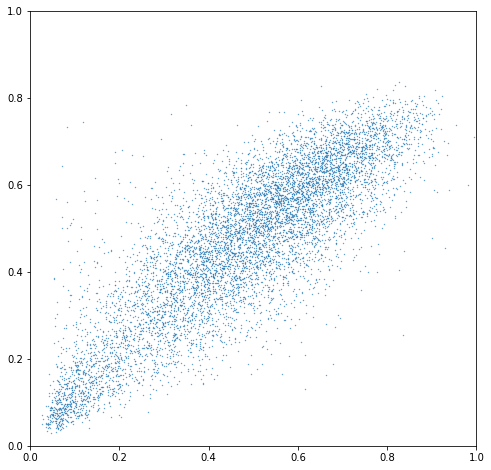

In [ ]:
import matplotlib.pyplot as plt
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'lstm/'
model = LSTM_model(word_model)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])


fold_var = 3
model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('test.csv')


sentences_test = splitkmer(test_data)
max_sentence_len = len(sentences_test[0])
test_x = np.zeros([len(sentences_test), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences_test):
  for t, word in enumerate(sentence):
    test_x[i, t] = word2idx(word, word_model)
print(test_x.shape)
print(test_x)

X_ = test_x

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))
savefigstring = 'lstm' + str(target_type) + '.png'
plt.savefig(savefigstring)

**GRU**

In [ ]:
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout
from scipy import stats

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

def GRU_model(word_model):
  pretrained_weights = word_model.wv.syn0
  vocab_size, emdedding_size = pretrained_weights.shape

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, 
                      weights=[pretrained_weights]))
  model.add(GRU(units=emdedding_size,return_sequences = True))
  model.add(Dropout(0.2))
  model.add(SimpleRNN(units = emdedding_size, return_sequences=False))
  model.add(Dropout(0.2))  
  model.add(Dense(1,activation = 'sigmoid'))
  return model
#word_model = return_vectors_word2vec(train_df,1)
#test_model = LSTM_model(word_model)
#print(test_model.summary())

In [ ]:
def word2idx(word, word_model):
  return word_model.wv.vocab[word].index
def idx2word(idx, word_model):
  return word_model.wv.index2word[idx]

In [ ]:
#word_model, vectors_returned = return_vectors_word2vec(train_df)
word_model = Word2Vec.load('word2vec_model_rnn')
sentences = splitkmer(train_df)
#print(len(sentences[0]))
max_sentence_len = len(sentences[0])
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence):
    train_x[i, t] = word2idx(word, word_model)
print(train_x.shape)
print(train_x)

100%|██████████| 45846/45846 [00:00<00:00, 79983.52it/s]


(45846, 10)
[[10  1 14 ...  1  4 48]
 [ 4  6 32 ... 31 54 12]
 [52  5 10 ... 52 52 34]
 ...
 [18 60 63 ...  6 13 12]
 [27 54  9 ... 19 44 26]
 [10 32  3 ... 30 38  1]]


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_type = 3
target_col = ''
if target_type == 1:
  target_col = 'Wt_Efficiency'
elif target_type == 2:
  target_col = 'eSpCas 9_Efficiency'
else:
  target_col = 'SpCas9-HF1_Efficiency'

train_data = pd.read_csv('train.csv')

X = train_x
#X = np.array(X)



Y = train_data[[target_col]]
#Y = Y[indices]
print(X.shape)
print(Y.shape)
#print(X)

(45846, 10)
(45846, 1)


In [ ]:
kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'gru/'

'''
try:
    os.mkdir(save_dir_primary)
except:
    pass
'''

os.chdir(save_dir_primary)
try:
    os.mkdir('gru/')
except:
    pass
os.chdir('gru/')
save_dir_2 = 'saved_models/'
try:
    os.mkdir(save_dir_2)
except:
    pass
os.chdir('..')
os.chdir('..')

fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]

    print(X_train.shape)
    print(Y_train.shape)
    print(X_val.shape)
    print(Y_val.shape)
    
    # CREATE NEW MODEL
    model = GRU_model(word_model)
    # COMPILE NEW MODEL
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+save_dir_2+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=50,
                batch_size=64,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

(36676, 10)
(36676, 1)
(9170, 10)
(9170, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 7s 9ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0151 - val_mean_squared_error: 0.0151

Epoch 00001: val_loss improved from inf to 0.01512, saving model to Type2/gru/saved_models/model_1.h5
Epoch 2/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0174 - mean_squared_error: 0.0174 - val_loss: 0.0143 - val_mean_squared_error: 0.0143

Epoch 00002: val_loss improved from 0.01512 to 0.01431, saving model to Type2/gru/saved_models/model_1.h5
Epoch 3/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0139 - val_mean_squared_error: 0.0139

Epoch 00003: val_loss improved from 0.01431 to 0.01395, saving model to Type2/gru/saved_models/model_1.h5
Epoch 4/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0135 - val_mean_squared_error: 0.0135

Epoch 00004: val_loss improved fro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 7s 8ms/step - loss: 0.0299 - mean_squared_error: 0.0299 - val_loss: 0.0158 - val_mean_squared_error: 0.0158

Epoch 00001: val_loss improved from inf to 0.01584, saving model to Type2/gru/saved_models/model_2.h5
Epoch 2/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 0.0158 - val_mean_squared_error: 0.0158

Epoch 00002: val_loss improved from 0.01584 to 0.01579, saving model to Type2/gru/saved_models/model_2.h5
Epoch 3/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 0.0141 - val_mean_squared_error: 0.0141

Epoch 00003: val_loss improved from 0.01579 to 0.01406, saving model to Type2/gru/saved_models/model_2.h5
Epoch 4/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0138 - val_mean_squared_error: 0.0138

Epoch 00004: val_loss improved fro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 7s 8ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - val_loss: 0.0153 - val_mean_squared_error: 0.0153

Epoch 00001: val_loss improved from inf to 0.01533, saving model to Type2/gru/saved_models/model_3.h5
Epoch 2/50
574/574 [==============================] - 4s 8ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0145 - val_mean_squared_error: 0.0145

Epoch 00002: val_loss improved from 0.01533 to 0.01451, saving model to Type2/gru/saved_models/model_3.h5
Epoch 3/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0154 - mean_squared_error: 0.0154 - val_loss: 0.0138 - val_mean_squared_error: 0.0138

Epoch 00003: val_loss improved from 0.01451 to 0.01383, saving model to Type2/gru/saved_models/model_3.h5
Epoch 4/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - val_loss: 0.0136 - val_mean_squared_error: 0.0136

Epoch 00004: val_loss improved fro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 7s 8ms/step - loss: 0.0300 - mean_squared_error: 0.0300 - val_loss: 0.0169 - val_mean_squared_error: 0.0169

Epoch 00001: val_loss improved from inf to 0.01693, saving model to Type2/gru/saved_models/model_4.h5
Epoch 2/50
574/574 [==============================] - 4s 8ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0163 - val_mean_squared_error: 0.0163

Epoch 00002: val_loss improved from 0.01693 to 0.01634, saving model to Type2/gru/saved_models/model_4.h5
Epoch 3/50
574/574 [==============================] - 4s 8ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0144 - val_mean_squared_error: 0.0144

Epoch 00003: val_loss improved from 0.01634 to 0.01444, saving model to Type2/gru/saved_models/model_4.h5
Epoch 4/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0141 - val_mean_squared_error: 0.0141

Epoch 00004: val_loss improved fro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 7s 8ms/step - loss: 0.0317 - mean_squared_error: 0.0317 - val_loss: 0.0156 - val_mean_squared_error: 0.0156

Epoch 00001: val_loss improved from inf to 0.01561, saving model to Type2/gru/saved_models/model_5.h5
Epoch 2/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 0.0147 - val_mean_squared_error: 0.0147

Epoch 00002: val_loss improved from 0.01561 to 0.01469, saving model to Type2/gru/saved_models/model_5.h5
Epoch 3/50
574/574 [==============================] - 4s 8ms/step - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0136 - val_mean_squared_error: 0.0136

Epoch 00003: val_loss improved from 0.01469 to 0.01359, saving model to Type2/gru/saved_models/model_5.h5
Epoch 4/50
574/574 [==============================] - 4s 8ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0133 - val_mean_squared_error: 0.0133

Epoch 00004: val_loss improved fro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 8091/8091 [00:00<00:00, 126710.03it/s]


(8091, 10)
[[36 51  8 ... 62 48 33]
 [42  4 10 ... 41 33 46]
 [11 34  1 ... 38 29 25]
 ...
 [27 37 35 ...  3 10 13]
 [18 41 25 ...  7  3 23]
 [ 4  0 39 ... 11 34  1]]
SpearmanrResult(correlation=0.8239278644233466, pvalue=0.0)


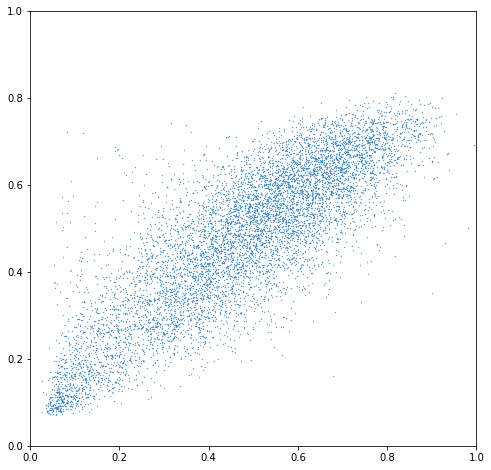

In [ ]:
import matplotlib.pyplot as plt
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'gru/'
model = GRU_model(word_model)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
fold_var = 3
model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('test.csv')


sentences_test = splitkmer(test_data)
max_sentence_len = len(sentences_test[0])
test_x = np.zeros([len(sentences_test), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences_test):
  for t, word in enumerate(sentence):
    test_x[i, t] = word2idx(word, word_model)
print(test_x.shape)
print(test_x)

X_ = test_x

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))
savefigstring = 'gru' + str(target_type) + '.png'
plt.savefig(savefigstring)

**Bi-LSTM**

In [ ]:
from keras.layers.recurrent import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Dropout, SpatialDropout1D, Bidirectional, Flatten
from scipy import stats

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

def BiLSTM_model(word_model):
  pretrained_weights = word_model.wv.syn0
  vocab_size, emdedding_size = pretrained_weights.shape

  model = Sequential()
  model.add(Embedding(input_dim=vocab_size, output_dim=emdedding_size, 
                      weights=[pretrained_weights], input_shape = (10,)))
  model.add(SpatialDropout1D(0.2))
  model.add(Bidirectional(LSTM(units=emdedding_size,return_sequences = True)))
  #model.add(Dense(64,activation = 'relu'))
  model.add(Flatten())
  model.add(Dense(1,activation = 'linear'))
  return model
#word_model = return_vectors_word2vec(train_df,1)
test_model = BiLSTM_model(word_model)
print(test_model.summary())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 10, 32)            2048      
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 10, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 64)            16640     
_________________________________________________________________
flatten_10 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 641       
Total params: 19,329
Trainable params: 19,329
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
def word2idx(word, word_model):
  return word_model.wv.vocab[word].index
def idx2word(idx, word_model):
  return word_model.wv.index2word[idx]

In [ ]:
#word_model, vectors_returned = return_vectors_word2vec(train_df)
word_model = Word2Vec.load('word2vec_model_rnn')
sentences = splitkmer(train_df)
#print(len(sentences[0]))
max_sentence_len = len(sentences[0])
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence):
    train_x[i, t] = word2idx(word, word_model)
print(train_x.shape)
print(train_x)

100%|██████████| 45846/45846 [00:00<00:00, 135258.63it/s]


(45846, 10)
[[10  1 14 ...  1  4 48]
 [ 4  6 32 ... 31 54 12]
 [52  5 10 ... 52 52 34]
 ...
 [18 60 63 ...  6 13 12]
 [27 54  9 ... 19 44 26]
 [10 32  3 ... 30 38  1]]


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_type = 3
target_col = ''
if target_type == 1:
  target_col = 'Wt_Efficiency'
elif target_type == 2:
  target_col = 'eSpCas 9_Efficiency'
else:
  target_col = 'SpCas9-HF1_Efficiency'

train_data = pd.read_csv('train.csv')

X = train_x
#X = np.array(X)



Y = train_data[[target_col]]
#Y = Y[indices]
print(X.shape)
print(Y.shape)
#print(X)

(45846, 10)
(45846, 1)


In [ ]:
kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'bilstm/'

'''
try:
    os.mkdir(save_dir_primary)
except:
    pass
'''

os.chdir(save_dir_primary)

try:
    os.mkdir('bilstm')
except:
    pass

os.chdir('bilstm/')
save_dir_2 = 'saved_models/'
try:
    
    os.mkdir(save_dir_2)
except:
    pass
os.chdir('..')
os.chdir('..')

fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]

    print(X_train.shape)
    print(Y_train.shape)
    print(X_val.shape)
    print(Y_val.shape)
    
    # CREATE NEW MODEL
    model = BiLSTM_model(word_model)
    # COMPILE NEW MODEL
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    
    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+save_dir_2+get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=50,
                batch_size=64,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

(36676, 10)
(36676, 1)
(9170, 10)
(9170, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 8s 9ms/step - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.0153 - val_mean_squared_error: 0.0153

Epoch 00001: val_loss improved from inf to 0.01529, saving model to Type2/bilstm/saved_models/model_1.h5
Epoch 2/50
574/574 [==============================] - 5s 9ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - val_loss: 0.0145 - val_mean_squared_error: 0.0145

Epoch 00002: val_loss improved from 0.01529 to 0.01446, saving model to Type2/bilstm/saved_models/model_1.h5
Epoch 3/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0140 - val_mean_squared_error: 0.0140

Epoch 00003: val_loss improved from 0.01446 to 0.01403, saving model to Type2/bilstm/saved_models/model_1.h5
Epoch 4/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0130 - val_mean_squared_error: 0.0130

Epoch 00004: val_loss imp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 8s 9ms/step - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.0165 - val_mean_squared_error: 0.0165

Epoch 00001: val_loss improved from inf to 0.01649, saving model to Type2/bilstm/saved_models/model_2.h5
Epoch 2/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0160 - val_mean_squared_error: 0.0160

Epoch 00002: val_loss improved from 0.01649 to 0.01605, saving model to Type2/bilstm/saved_models/model_2.h5
Epoch 3/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0159 - mean_squared_error: 0.0159 - val_loss: 0.0148 - val_mean_squared_error: 0.0148

Epoch 00003: val_loss improved from 0.01605 to 0.01476, saving model to Type2/bilstm/saved_models/model_2.h5
Epoch 4/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0139 - val_mean_squared_error: 0.0139

Epoch 00004: val_loss imp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 8s 9ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0164 - val_mean_squared_error: 0.0164

Epoch 00001: val_loss improved from inf to 0.01644, saving model to Type2/bilstm/saved_models/model_3.h5
Epoch 2/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0170 - mean_squared_error: 0.0170 - val_loss: 0.0152 - val_mean_squared_error: 0.0152

Epoch 00002: val_loss improved from 0.01644 to 0.01521, saving model to Type2/bilstm/saved_models/model_3.h5
Epoch 3/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0143 - val_mean_squared_error: 0.0143

Epoch 00003: val_loss improved from 0.01521 to 0.01431, saving model to Type2/bilstm/saved_models/model_3.h5
Epoch 4/50
574/574 [==============================] - 5s 8ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0140 - val_mean_squared_error: 0.0140

Epoch 00004: val_loss imp

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 10s 13ms/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0161 - val_mean_squared_error: 0.0161

Epoch 00001: val_loss improved from inf to 0.01608, saving model to Type2/bilstm/saved_models/model_4.h5
Epoch 2/50
574/574 [==============================] - 6s 11ms/step - loss: 0.0173 - mean_squared_error: 0.0173 - val_loss: 0.0150 - val_mean_squared_error: 0.0150

Epoch 00002: val_loss improved from 0.01608 to 0.01498, saving model to Type2/bilstm/saved_models/model_4.h5
Epoch 3/50
574/574 [==============================] - 6s 11ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 0.0149 - val_mean_squared_error: 0.0149

Epoch 00003: val_loss improved from 0.01498 to 0.01487, saving model to Type2/bilstm/saved_models/model_4.h5
Epoch 4/50
574/574 [==============================] - 6s 11ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - val_loss: 0.0153 - val_mean_squared_error: 0.0153

Epoch 00004: val_los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/50
574/574 [==============================] - 10s 12ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0156 - val_mean_squared_error: 0.0156

Epoch 00001: val_loss improved from inf to 0.01555, saving model to Type2/bilstm/saved_models/model_5.h5
Epoch 2/50
574/574 [==============================] - 6s 11ms/step - loss: 0.0172 - mean_squared_error: 0.0172 - val_loss: 0.0146 - val_mean_squared_error: 0.0146

Epoch 00002: val_loss improved from 0.01555 to 0.01464, saving model to Type2/bilstm/saved_models/model_5.h5
Epoch 3/50
574/574 [==============================] - 7s 11ms/step - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 0.0144 - val_mean_squared_error: 0.0144

Epoch 00003: val_loss improved from 0.01464 to 0.01444, saving model to Type2/bilstm/saved_models/model_5.h5
Epoch 4/50
574/574 [==============================] - 6s 11ms/step - loss: 0.0153 - mean_squared_error: 0.0153 - val_loss: 0.0139 - val_mean_squared_error: 0.0139

Epoch 00004: val_los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 8091/8091 [00:00<00:00, 145293.12it/s]


(8091, 10)
[[36 51  8 ... 62 48 33]
 [42  4 10 ... 41 33 46]
 [11 34  1 ... 38 29 25]
 ...
 [27 37 35 ...  3 10 13]
 [18 41 25 ...  7  3 23]
 [ 4  0 39 ... 11 34  1]]
SpearmanrResult(correlation=0.830329784439046, pvalue=0.0)


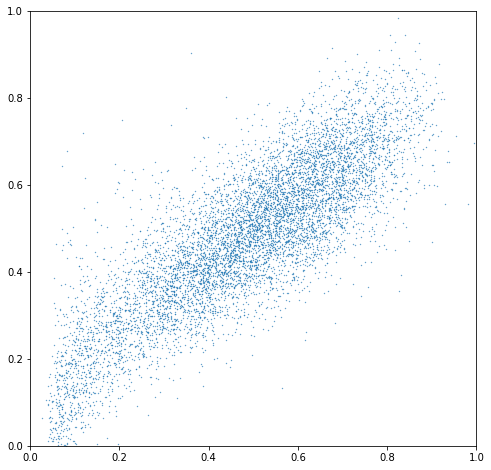

In [ ]:
import matplotlib.pyplot as plt
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'bilstm/'
model = model = BiLSTM_model(word_model)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
fold_var = 3
model.load_weights(save_dir + "saved_models/model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('test.csv')


sentences_test = splitkmer(test_data)
max_sentence_len = len(sentences_test[0])
test_x = np.zeros([len(sentences_test), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences_test):
  for t, word in enumerate(sentence):
    test_x[i, t] = word2idx(word, word_model)
print(test_x.shape)
print(test_x)

X_ = test_x

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))
savefigstring = 'bilstm' + str(target_type) + '.png'
plt.savefig(savefigstring)

**Bi-LSTM with Attention**

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional, GRU, Dropout
from tensorflow.keras import backend as K
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras.layers import Layer


def get_model_name(k):
    return 'att_bilstm_model_'+str(k)+'.h5'


class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2
            hidden = LSTM(64, return_sequences=True)(words)
            sentence = Attention()(hidden)
            # next add a Dense layer (for classification/regression) or whatever...
        """
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0

        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(name='{}_W'.format(self.name),
                                 shape=(input_shape[-1],),
                                 initializer=self.init,
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(name='{}_b'.format(self.name),
                                     shape=(input_shape[1],),
                                     initializer='zero',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        e = K.reshape(K.dot(K.reshape(x, (-1, features_dim)), K.reshape(self.W, (features_dim, 1))), (-1, step_dim))  # e = K.dot(x, self.W)
        if self.bias:
            e += self.b
        e = K.tanh(e)

        a = K.exp(e)
        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())
        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        a = K.expand_dims(a)

        c = K.sum(a * x, axis=1)
        return c

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim

class TextAttBiRNN(Model):
    def __init__(self,
                 maxlen,
                 max_features,
                 embedding_dims,
                 class_num=1,
                 last_activation='linear'):
        super(TextAttBiRNN, self).__init__()
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation
        self.embedding = Embedding(self.max_features, self.embedding_dims, input_length=self.maxlen)
        self.bi_rnn = Bidirectional(LSTM(128, return_sequences=True))  # LSTM or GRU
        self.attention = Attention(self.maxlen)
        self.internal = Dense(64, activation='relu')
        self.dropout = Dropout(0.25)
        self.classifier = Dense(self.class_num, activation=self.last_activation)

    def call(self, inputs):
        if len(inputs.get_shape()) != 2:
            raise ValueError('The rank of inputs of TextAttBiRNN must be 2, but now is %d' % len(inputs.get_shape()))
        if inputs.get_shape()[1] != self.maxlen:
            raise ValueError('The maxlen of inputs of TextAttBiRNN must be %d, but now is %d' % (self.maxlen, inputs.get_shape()[1]))
        embedding = self.embedding(inputs)
        x = self.bi_rnn(embedding)
        x = self.attention(x)
        x = self.internal(x)
        x = self.dropout(x)
        output = self.classifier(x)
        return output



In [ ]:
def word2idx(word, word_model):
  return word_model.wv.vocab[word].index
def idx2word(idx, word_model):
  return word_model.wv.index2word[idx]

In [ ]:
word_model = Word2Vec.load('word2vec_model_rnn')
sentences = splitkmer(train_df)
#print(len(sentences[0]))
max_sentence_len = len(sentences[0])
train_x = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence):
    train_x[i, t] = word2idx(word, word_model)
print(train_x.shape)
print(train_x)

100%|██████████| 45846/45846 [00:00<00:00, 84568.63it/s]


(45846, 10)
[[10  1 14 ...  1  4 48]
 [ 4  6 32 ... 31 54 12]
 [52  5 10 ... 52 52 34]
 ...
 [18 60 63 ...  6 13 12]
 [27 54  9 ... 19 44 26]
 [10 32  3 ... 30 38  1]]


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf

target_type = 3
target_col = ''
if target_type == 1:
  target_col = 'Wt_Efficiency'
elif target_type == 2:
  target_col = 'eSpCas 9_Efficiency'
else:
  target_col = 'SpCas9-HF1_Efficiency'

train_data = pd.read_csv('train.csv')

X = train_x
#X = np.array(X)



Y = train_data[[target_col]]
#Y = Y[indices]
print(X.shape)
print(Y.shape)
#print(X)

(45846, 10)
(45846, 1)


In [ ]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import sequence
from scipy import stats

max_features = 64
maxlen = 10
batch_size = 64

embedding_dims = 32


kf = KFold(n_splits = 5, shuffle=True, random_state=0)


VALIDATION_CORR = []
VALIDATION_LOSS = []

save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'attention/'

'''
try:
    os.mkdir(save_dir_primary)
except:
    pass
'''

os.chdir(save_dir_primary)

try:
    os.mkdir('attention')
except:
    pass

os.chdir('attention/')
save_dir_2 = 'saved_models/'
try:
    
    os.mkdir(save_dir_2)
except:
    pass
os.chdir('..')
os.chdir('..')

fold_var = 1

for train_index, val_index in kf.split(X,Y):
    X_train = X[train_index]
    Y_train = Y.iloc[train_index]
    X_val = X[val_index]
    Y_val = Y.iloc[val_index]
    

    model = TextAttBiRNN(maxlen, max_features, embedding_dims)
    model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
    

    # CREATE CALLBACKS
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + save_dir_2 +get_model_name(fold_var), 
                            monitor='val_loss', verbose=1, 
                            save_best_only=True, mode='min')
    callbacks_list = [checkpoint, es]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history = model.fit(X_train,Y_train,
                epochs=100,
                batch_size=batch_size,
                callbacks=callbacks_list,
                validation_data=(X_val, Y_val))
    #PLOT HISTORY
    #       :
    #       :
    
    # LOAD BEST MODEL to evaluate the performance of the model
    model.load_weights(save_dir + "saved_models/att_bilstm_model_"+str(fold_var)+".h5")
    
    results = model.evaluate(X_val, Y_val)
    results = dict(zip(model.metrics_names,results))
    
    Y_pred = model.predict(X_val)
    Y_val = np.array(Y_val).reshape(len(Y_val),1)
    spearmancorr = (stats.spearmanr(Y_pred,Y_val))

    with open(save_dir + "saved_models/att_bilstm_spcorr_val_"+str(fold_var)+".txt", "w") as f:
        f.write(str(spearmancorr))

    VALIDATION_CORR.append(spearmancorr)
    VALIDATION_LOSS.append(results['loss'])
    
    tf.keras.backend.clear_session()
    
    fold_var += 1

print(VALIDATION_LOSS)
print(np.mean(VALIDATION_LOSS))
print(VALIDATION_CORR)
print(np.mean(VALIDATION_CORR))

Epoch 1/100
574/574 [==============================] - 24s 35ms/step - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.0216 - val_mean_squared_error: 0.0216

Epoch 00001: val_loss improved from inf to 0.02155, saving model to Type2/attention/saved_models/att_bilstm_model_1.h5
Epoch 2/100
574/574 [==============================] - 19s 34ms/step - loss: 0.0213 - mean_squared_error: 0.0213 - val_loss: 0.0179 - val_mean_squared_error: 0.0179

Epoch 00002: val_loss improved from 0.02155 to 0.01790, saving model to Type2/attention/saved_models/att_bilstm_model_1.h5
Epoch 3/100
574/574 [==============================] - 19s 33ms/step - loss: 0.0184 - mean_squared_error: 0.0184 - val_loss: 0.0160 - val_mean_squared_error: 0.0160

Epoch 00003: val_loss improved from 0.01790 to 0.01603, saving model to Type2/attention/saved_models/att_bilstm_model_1.h5
Epoch 4/100
574/574 [==============================] - 19s 33ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0146 - val

1/1 [==============================] - 3s 3s/step - loss: 0.2589 - mean_squared_error: 0.2589


100%|██████████| 8091/8091 [00:00<00:00, 145904.05it/s]


(8091, 10)
[[36 51  8 ... 62 48 33]
 [42  4 10 ... 41 33 46]
 [11 34  1 ... 38 29 25]
 ...
 [27 37 35 ...  3 10 13]
 [18 41 25 ...  7  3 23]
 [ 4  0 39 ... 11 34  1]]
SpearmanrResult(correlation=0.8333928341090534, pvalue=0.0)


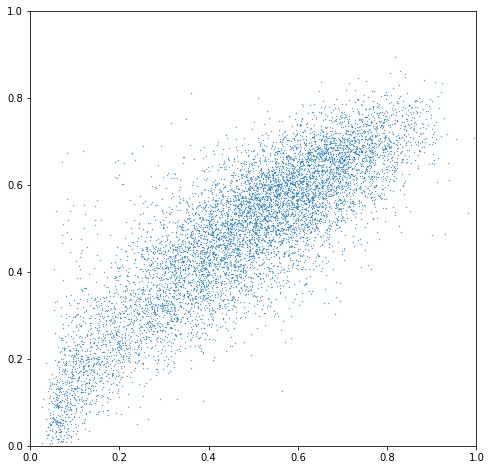

In [ ]:
import matplotlib.pyplot as plt
save_dir_primary = 'Type' + str(target_type) + '/'
save_dir = save_dir_primary + 'attention/'
model = TextAttBiRNN(10, 64, 32)
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error'])
model.fit(X[0].reshape(1,10),Y.iloc[0],epochs=1,batch_size=1)
fold_var = 3
model.load_weights(save_dir + "saved_models/att_bilstm_model_"+str(fold_var)+".h5")
    
test_data = pd.read_csv('test.csv')


sentences_test = splitkmer(test_data)
max_sentence_len = len(sentences_test[0])
test_x = np.zeros([len(sentences_test), max_sentence_len], dtype=np.int32)
for i, sentence in enumerate(sentences_test):
  for t, word in enumerate(sentence):
    test_x[i, t] = word2idx(word, word_model)
print(test_x.shape)
print(test_x)

X_ = test_x

Y_ = test_data[[target_col]] # Y dataframe with single column; use iloc

Y_pred = model.predict(X_)
Y_ = np.array(Y_).reshape(len(Y_),1)
spearmancorr = (stats.spearmanr(Y_pred,Y_))

print(spearmancorr)
plt.figure(figsize=(8,8))
plt.scatter(Y_, Y_pred, s=0.1)
plt.ylim((0,1))
plt.xlim((0,1))
savefigstring = 'attention' + str(target_type) + '.png'
plt.savefig(savefigstring)